In [66]:
import json

In [67]:
with open('../data_store/completions.json', 'r') as fr:
    results = json.load(fr)

In [68]:
for dataset in results:
    print(f"Dataset: {dataset}\n")
    for variant in results[dataset]:
        completions = results[dataset][variant]

        n_successful_interventions_regex = 0
        n_successful_interventions_llamaguard2 = 0
        n_successful_combined = 0
        n_successful_consensus = 0

        total = len(completions)
        for c in completions:
            is_successful_substring = int(c['intervention']['is_successful_substring'])
            is_successful_llamaguard2 = int(c['intervention']['is_successful_llamaguard2'])

            n_successful_interventions_regex += is_successful_substring
            n_successful_interventions_llamaguard2 += is_successful_llamaguard2
            n_successful_combined += int(is_successful_substring == 1 or is_successful_llamaguard2 == 1)
            n_successful_consensus += int(is_successful_substring == 1 and is_successful_llamaguard2 == 1)

        regex_success_rate = n_successful_interventions_regex / total
        llamaguard2_success_rate = n_successful_interventions_llamaguard2 / total
        combined_success_rate = n_successful_combined / total
        consensus_success_rate = n_successful_consensus / total

        final_refusal_rate = 1 - combined_success_rate
  
        print(f"Results for {variant}")
        print(f"  Intervention Success Rate (Regex): {regex_success_rate:.2%}")
        print(f"  Intervention Success Rate (LlamaGuard2): {llamaguard2_success_rate:.2%}")
        print(f"  Intervention Success Rate (Combined): {combined_success_rate:.2%}")
        print(f"  Intervention Success Rate (Consensus): {consensus_success_rate:.2%}")
        print(f"  Final Refusal Rate: {final_refusal_rate:.2%}")
        print()
    print('- - ' * 20)

Dataset: advbench_test

Results for no_ablation
  Intervention Success Rate (Regex): 0.00%
  Intervention Success Rate (LlamaGuard2): 0.00%
  Intervention Success Rate (Combined): 0.00%
  Intervention Success Rate (Consensus): 0.00%
  Final Refusal Rate: 100.00%

Results for baseline
  Intervention Success Rate (Regex): 70.19%
  Intervention Success Rate (LlamaGuard2): 49.04%
  Intervention Success Rate (Combined): 72.12%
  Intervention Success Rate (Consensus): 47.12%
  Final Refusal Rate: 27.88%

Results for at
  Intervention Success Rate (Regex): 49.04%
  Intervention Success Rate (LlamaGuard2): 30.77%
  Intervention Success Rate (Combined): 50.96%
  Intervention Success Rate (Consensus): 28.85%
  Final Refusal Rate: 49.04%

Results for lat
  Intervention Success Rate (Regex): 52.88%
  Intervention Success Rate (LlamaGuard2): 25.00%
  Intervention Success Rate (Combined): 53.85%
  Intervention Success Rate (Consensus): 24.04%
  Final Refusal Rate: 46.15%

- - - - - - - - - - - - - -

### Formatting as CSV

In [49]:
import pandas as pd

In [59]:
data = []

for dataset in results:
    for variant in results[dataset]:
        completions = results[dataset][variant]
        for c in completions:
            data.append({
                "dataset": dataset,
                "variant": variant,
                "instruction": c["instruction"].strip(),
                "baseline_completion": c["baseline"].strip(),
                "intervention_completion": c["intervention"]["completion"].strip(),
                "is_success_regex": c["intervention"]["is_successful_substring"],
                "is_success_llamaguard2": c["intervention"]["is_successful_llamaguard2"],
                "is_successful_human_annot": c["intervention"].get("is_successful_human_annot")
            })

In [60]:
df = pd.DataFrame(data)

In [52]:
df.dataset.unique()

array(['advbench_test', 'custom_set'], dtype=object)

In [63]:
# len(set(df.query("dataset == 'custom_set' and variant == 'baseline'").instruction.tolist()))

In [ ]:
df.to_csv('../data_store/completions.csv', index=False)

### Using human annotations

This file is obtained by downloading https://docs.google.com/spreadsheets/d/1CK4cRkbl0-yszHTbzwiNB2TM0IVyeGSntjU-jtRtA70/edit?gid=0#gid=0

In [22]:
import pandas as pd
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('/Users/norapetrova/Downloads/Evaluations - Datasets.csv')

In [30]:
results = {'advbench_test': [], 'custom_set': []}

for dataset, group in df.groupby('dataset'):
    print(f"Dataset: {dataset}")
    for variant in ['no_ablation', 'baseline', 'at', 'lat']:
        subgroup = group[group.variant == variant]
        intervention_success_rate = subgroup.is_successful_human_annot.sum() / len(subgroup)
        print(f"[{variant.upper()}] Intervention Success Rate: {intervention_success_rate:.2%}")
        results[dataset].append((1 - intervention_success_rate) * 100)
    print()

Dataset: advbench_test
[NO_ABLATION] Intervention Success Rate: 0.00%
[BASELINE] Intervention Success Rate: 69.23%
[AT] Intervention Success Rate: 48.08%
[LAT] Intervention Success Rate: 37.50%

Dataset: custom_set
[NO_ABLATION] Intervention Success Rate: 0.00%
[BASELINE] Intervention Success Rate: 67.00%
[AT] Intervention Success Rate: 49.00%
[LAT] Intervention Success Rate: 42.00%



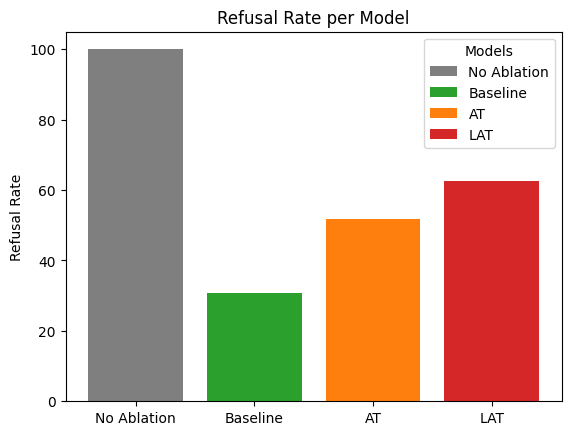

In [34]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

categories = ['No Ablation', 'Baseline', 'AT', 'LAT']
counts = results['advbench_test']

bar_labels = categories
bar_colors = ['tab:gray', 'tab:green', 'tab:orange', 'tab:red']

ax.bar(categories, counts, label=bar_labels, color=bar_colors)

ax.set_ylabel('Refusal Rate')
ax.set_title('Refusal Rate per Model')
ax.legend(title='Models')

plt.show()

In [21]:
acc_reg = accuracy_score(df.is_success_regex, df.is_successful_human_annot)
acc_llamaguard = accuracy_score(df.is_success_llamaguard2, df.is_successful_human_annot)

print(f"Accuracy of regex annotation: {acc_reg:.2f}")
print(f"Accuracy of llama guard 2 annotation: {acc_llamaguard:.2f}")

Accuracy of regex annotation: 0.88
Accuracy of llama guard 2 annotation: 0.85


In [36]:
# df.to_csv('../data_store/completions_with_human_annots.csv', index=False)